In [1]:
import pandas as pd
import geopandas as gpd
import time
import pickle
import os
import numpy as np
import xgboost
import pytz
import arcgis
#
#plotting
#'''
from IPython.display import HTML, display
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
#'''

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import NullFormatter
import matplotlib as mpl
mpl.rc('xtick', color='k')
mpl.rc('ytick', color='k')
%matplotlib inline
#'''

C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [535]:
with open('wrangler.pkl','rb') as fp:
    wrangler = pickle.load(fp)

float_scaler_mean = wrangler['float_scaler_mean']
float_scaler_std = wrangler['float_scaler_std']
float_feature_names = wrangler['float_feature_names']
ohe_fields = wrangler['ohe_fields']
feature_names = wrangler['feature_names']
    
booster = xgboost.Booster()
booster.load_model('0001.model')

In [3]:
project_gdb = r'C:\Users\dani9510\Documents\ArcGIS\Projects\Utah Accidents Demo\Utah Accidents Demo.gdb'
collisions_path = os.path.join(project_gdb,'UtahCollisions_OnRoads')
road_features_path = os.path.join(project_gdb,'Utah_Road_StaticFeatures')

In [4]:
#df = arcgis.SpatialDataFrame().from_featureclass(collisions_path)
#rdf = arcgis.SpatialDataFrame().from_featureclass(road_features_path)

In [5]:
utah_tz = pytz.timezone('US/Mountain')

In [370]:
road_features = pd.read_csv('training_data/road_features.csv')

In [7]:
collisions =  pd.read_csv('training_data/collisions.csv')

C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
tidx = pd.DatetimeIndex(collisions['timestamp']).floor('H')
tidx = tidx.tz_localize(utah_tz,ambiguous='NaT')

In [9]:
#collisions['timestamp'] = pd.to_datetime(collisions.timestamp).map(utah_tz.localize)
collisions = collisions.set_index(tidx)
collisions.sort_index(inplace=True)

In [10]:
collisions['hour'] = collisions.index.hour
collisions['weekday'] = collisions.index.weekday
collisions['month'] = collisions.index.month

In [11]:
wdf = pd.read_csv('utah_weather_2010-2018_grouped.csv')

In [12]:
wdf['timestamp'] = pd.to_datetime(wdf.timestamp).map(pytz.utc.localize)
wdf['timestamp'] = wdf['timestamp'].map(lambda x: x.astimezone(utah_tz))

In [13]:
wdf = wdf.set_index('timestamp')

In [14]:
road_features.head(100)

,segment_id,OBJECTID,Join_Count,TARGET_FID,ADDR_SYS,full_name,pre_dir,street_type,suf_dir,zip_left,...,segment_length,near_major_road,road_orient_approx,at_intersection,near_billboard,Shape_Length_1,station_id,station_name,SHAPE,accident_counts
0,1,1,1,1,MANTI,100 N,W,,N,84642,...,205.165412,0,3.140475,0,0,3.634361,99999923162,DELTA FAA AP,"{""paths"": [[[-12427584.6731, 4759977.418200001...",1.0
1,2,2,1,2,MANTI,LEFT FORK MAIN CANYON RD,,RD,,84630,...,3185.236078,0,1.136780,0,0,3.634361,99999923162,DELTA FAA AP,"{""paths"": [[[-12435777.2227, 4767891.698399998...",0.0
2,3,3,1,3,MANTI,EPHRAIM RIVER LN,N,LN,,84630,...,515.779386,0,1.608032,0,0,3.634361,99999923162,DELTA FAA AP,"{""paths"": [[[-12432455.7623, 4774082.840400003...",0.0
3,4,4,1,4,MANTI,DRY CANYON RD,,RD,,84630,...,5961.648532,0,2.341077,0,0,3.634361,99999923162,DELTA FAA AP,"{""paths"": [[[-12434954.3488, 4775258.3002], [-...",0.0
4,5,5,1,5,MANTI,SPRING CITY POND RD,E,RD,,84623,...,1607.124124,0,0.144767,0,0,3.446158,72572424174,PROVO MUNICIPAL AIRPORT,"{""paths"": [[[-12416539.9803, 4791893.570100002...",0.0
5,6,6,1,6,MANTI,DRY CANYON RD,,RD,,84630,...,2213.997782,0,2.721297,0,0,3.634361,99999923162,DELTA FAA AP,"{""paths"": [[[-12433554.076000001, 4774632.4808...",0.0
6,7,7,1,7,MANTI,HOLLOW RD,E,RD,,84662,...,1193.327442,0,0.005229,0,0,4.954030,72470093141,CARBON COUNTY AIRPORT,"{""paths"": [[[-12414820.2393, 4781729.199299999...",0.0
7,8,8,1,8,CENTERFIELD,200 N,W,,N,84622,...,226.700042,0,3.132514,0,0,3.634361,99999923162,DELTA FAA AP,"{""paths"": [[[-12448702.149500001, 4740387.9341...",0.0
8,9,9,1,9,EPHRAIM,BLACK HILL RD,E,RD,,84627,...,739.579540,0,0.007784,0,0,4.954030,72470093141,CARBON COUNTY AIRPORT,"{""paths"": [[[-12420734.0107, 4774682.221699998...",0.0
9,10,10,1,10,MANTI,LARSON RD,E,RD,,84627,...,185.804519,0,0.088260,0,0,3.446158,72572424174,PROVO MUNICIPAL AIRPORT,"{""paths"": [[[-12420711.321600001, 4776558.9852...",0.0


In [371]:
import geopandas as gpd
import json
import numpy as np
from shapely.geometry import LineString, Point, box

In [372]:
paths = road_features.SHAPE.map(lambda x: np.array(json.loads(x)['paths'][0]))

In [373]:
pathLineStrings = paths.map(LineString)

In [374]:
gdf = gpd.GeoDataFrame(road_features,geometry=pathLineStrings)
gdf.crs = {'init': 'epsg:3857'}
#gdf.crs = {'init': 'epsg:4326'}

In [375]:
gdf.head()

,segment_id,OBJECTID_1,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,OBJECTID,pre_dir,street_type,suf_dir,...,euclidean_length,segment_length,at_intersection,near_billboard,road_orient_approx,near_major_road,station_id,SHAPE,accident_counts,geometry
0,1,1,1.0,1.0,1,1,1552669.0,N,,,...,110.198977,110.198977,1,0,1.022803,0,72572024127,"{""paths"": [[[-12456864.7474, 4990912.831799999...",4.0,"LINESTRING (-12456864.7474 4990912.831799999, ..."
1,2,2,1.0,2.0,1,2,1552670.0,N,,,...,87.835598,87.835598,1,0,1.187714,0,72572024127,"{""paths"": [[[-12457637.5934, 4989427.5832], [-...",7.0,"LINESTRING (-12457637.5934 4989427.5832, -1245..."
2,3,3,1.0,3.0,1,3,1552671.0,,,,...,92.241146,92.241146,0,0,1.439035,0,72572024127,"{""paths"": [[[-12458358.133200001, 4987379.1040...",0.0,"LINESTRING (-12458358.1332 4987379.104000002, ..."
3,4,4,1.0,4.0,1,4,1552678.0,S,ST,,...,256.607449,256.607449,1,1,1.565687,0,72470093141,"{""paths"": [[[-12421819.4298, 4772828.893700004...",9.0,"LINESTRING (-12421819.4298 4772828.893700004, ..."
4,5,5,1.0,5.0,1,5,1558703.0,E,PKWY,,...,594.164555,601.122608,0,0,0.189724,0,72572024127,"{""paths"": [[[-12452402.4137, 4942914.066], [-1...",68.0,"LINESTRING (-12452402.4137 4942914.066, -12452..."


In [376]:
gdf = gdf.to_crs({'init': 'epsg:4326'})

In [377]:
x0 = -112.8
x1 = -111.0
y0 = 39.6
y1 = 41.6
SLC = box(x0,y0,x1,y1)

In [378]:
slc_df = gdf[gdf.intersects(SLC)]

In [379]:
slc_df.head()

,segment_id,OBJECTID_1,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,OBJECTID,pre_dir,street_type,suf_dir,...,euclidean_length,segment_length,at_intersection,near_billboard,road_orient_approx,near_major_road,station_id,SHAPE,accident_counts,geometry
0,1,1,1.0,1.0,1,1,1552669.0,N,,,...,110.198977,110.198977,1,0,1.022803,0,72572024127,"{""paths"": [[[-12456864.7474, 4990912.831799999...",4.0,LINESTRING (-111.9019199479908 40.854559483967...
1,2,2,1.0,2.0,1,2,1552670.0,N,,,...,87.835598,87.835598,1,0,1.187714,0,72572024127,"{""paths"": [[[-12457637.5934, 4989427.5832], [-...",7.0,LINESTRING (-111.9088625417315 40.844467030743...
2,3,3,1.0,3.0,1,3,1552671.0,,,,...,92.241146,92.241146,0,0,1.439035,0,72572024127,"{""paths"": [[[-12458358.133200001, 4987379.1040...",0.0,LINESTRING (-111.9153352608831 40.830544831886...
4,5,5,1.0,5.0,1,5,1558703.0,E,PKWY,,...,594.164555,601.122608,0,0,0.189724,0,72572024127,"{""paths"": [[[-12452402.4137, 4942914.066], [-1...",68.0,LINESTRING (-111.8618341223353 40.527624319805...
5,6,6,1.0,6.0,1,6,1558706.0,W,RD,,...,502.492420,502.589810,0,0,1.860888,0,9999994133,"{""paths"": [[[-12404374.7157, 4922777.780199997...",1.0,LINESTRING (-111.4303939705905 40.389992171584...


C:\Users\dani9510\AppData\Local\ESRI\conda\envs\venv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


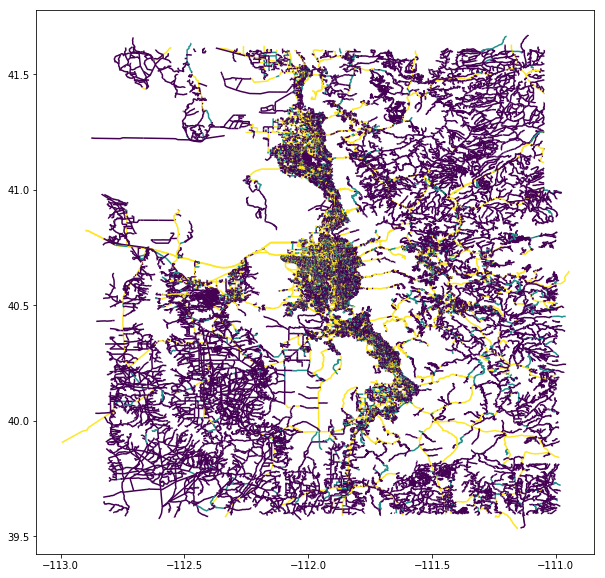

In [380]:
fig, ax = plt.subplots()
fig.set_size_inches((10,10))
#help(gdf.plot)
slc_df['scaled'] = slc_df['accident_counts']
slc_df.plot(ax=ax,column='scaled',scheme='quantiles')

In [381]:
slc_df.head()

,segment_id,OBJECTID_1,Join_Count,TARGET_FID,Join_Count_1,TARGET_FID_1,OBJECTID,pre_dir,street_type,suf_dir,...,segment_length,at_intersection,near_billboard,road_orient_approx,near_major_road,station_id,SHAPE,accident_counts,geometry,scaled
0,1,1,1.0,1.0,1,1,1552669.0,N,,,...,110.198977,1,0,1.022803,0,72572024127,"{""paths"": [[[-12456864.7474, 4990912.831799999...",4.0,LINESTRING (-111.9019199479908 40.854559483967...,4.0
1,2,2,1.0,2.0,1,2,1552670.0,N,,,...,87.835598,1,0,1.187714,0,72572024127,"{""paths"": [[[-12457637.5934, 4989427.5832], [-...",7.0,LINESTRING (-111.9088625417315 40.844467030743...,7.0
2,3,3,1.0,3.0,1,3,1552671.0,,,,...,92.241146,0,0,1.439035,0,72572024127,"{""paths"": [[[-12458358.133200001, 4987379.1040...",0.0,LINESTRING (-111.9153352608831 40.830544831886...,0.0
4,5,5,1.0,5.0,1,5,1558703.0,E,PKWY,,...,601.122608,0,0,0.189724,0,72572024127,"{""paths"": [[[-12452402.4137, 4942914.066], [-1...",68.0,LINESTRING (-111.8618341223353 40.527624319805...,68.0
5,6,6,1.0,6.0,1,6,1558706.0,W,RD,,...,502.589810,0,0,1.860888,0,9999994133,"{""paths"": [[[-12404374.7157, 4922777.780199997...",1.0,LINESTRING (-111.4303939705905 40.389992171584...,1.0


In [536]:
predTimest = pd.date_range('01/06/2017', periods=7*24, freq='H',tz='US/Mountain')

In [537]:
predTimest

DatetimeIndex(['2017-01-06 00:00:00-07:00', '2017-01-06 01:00:00-07:00',
               '2017-01-06 02:00:00-07:00', '2017-01-06 03:00:00-07:00',
               '2017-01-06 04:00:00-07:00', '2017-01-06 05:00:00-07:00',
               '2017-01-06 06:00:00-07:00', '2017-01-06 07:00:00-07:00',
               '2017-01-06 08:00:00-07:00', '2017-01-06 09:00:00-07:00',
               ...
               '2017-01-12 14:00:00-07:00', '2017-01-12 15:00:00-07:00',
               '2017-01-12 16:00:00-07:00', '2017-01-12 17:00:00-07:00',
               '2017-01-12 18:00:00-07:00', '2017-01-12 19:00:00-07:00',
               '2017-01-12 20:00:00-07:00', '2017-01-12 21:00:00-07:00',
               '2017-01-12 22:00:00-07:00', '2017-01-12 23:00:00-07:00'],
              dtype='datetime64[ns, US/Mountain]', length=168, freq='H')

In [581]:
prediction_time = predTimest[15]

In [582]:
test_df = slc_df.copy()

In [583]:
test_df['timestamp'] = prediction_time
test_df['station_id'] = slc_df.station_id.astype('int64')
test_df['hour'] = prediction_time.hour
test_df['weekday'] = prediction_time.weekday()
test_df['month'] = prediction_time.month

In [584]:
def add_join_key(df):
    df['join_key'] = df.station_id.map(int).map(str)+df.timestamp.map(datetime.datetime.isoformat)
    df = df.set_index('join_key')
    return df

In [585]:
weath_df = wdf.loc[prediction_time]

In [586]:
test_df = add_join_key(test_df)
weath_df = add_join_key(weath_df.reset_index())


In [587]:
test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))

In [588]:
test_df.columns

Index(['segment_id', 'OBJECTID_1', 'Join_Count', 'TARGET_FID', 'Join_Count_1',
       'TARGET_FID_1', 'OBJECTID', 'pre_dir', 'street_type', 'suf_dir',
       'one_way', 'speed_limit', 'surface_type', 'surface_width', 'aadt',
       'sinuosity', 'euclidean_length', 'segment_length', 'at_intersection',
       'near_billboard', 'road_orient_approx', 'near_major_road', 'station_id',
       'SHAPE', 'accident_counts', 'geometry', 'scaled', 'timestamp', 'hour',
       'weekday', 'month', 'snowing', 'raining', 'foggy', 'icy', 'hailing',
       'thunderstorm', 'wind_speed', 'visibility', 'temperature',
       'precip_depth', 'snow_depth'],
      dtype='object')

In [589]:
def make_test_set(df,wrangler):
    float_scaler_mean = wrangler['float_scaler_mean']
    float_scaler_std = wrangler['float_scaler_std']
    float_feature_names = wrangler['float_feature_names']
    drop_columns = wrangler['drop_columns']
    ohe_fields = wrangler['ohe_fields']
    feature_names = wrangler['feature_names']
    print(len(feature_names))
    df_ohe = pd.get_dummies(df,columns=ohe_fields)

    float_features = df.xs(float_feature_names,axis=1).values
    float_features = (float_features - float_scaler_mean) / float_scaler_std
    for i,fname in enumerate(float_feature_names):
        df_ohe[fname] = float_features[:,i]
        
    empty_features = list(set(feature_names) - set(df_ohe.columns.tolist()))
    
    #for f in empty_features:
    #    df_ohe[f] = 0
    
    df_ohe = df_ohe[feature_names]#.drop(columns=['SegID.1','geometry','SHAPE']+drop_columns,errors='ignore')
    
    #print(df_ohe.columns)
    #print(df_ohe.columns.tolist())
    X = df_ohe.values
    feature_names = df_ohe.columns.tolist()
    return X, feature_names


    

In [590]:
import matplotlib.colors as c
help(c.LinearSegmentedColormap.from_list)
cmap = c.LinearSegmentedColormap.from_list('traffic',['g','g','g','y','orange','r','darkred'])

Help on function from_list in module matplotlib.colors:

from_list(name, colors, N=256, gamma=1.0)
    Make a linear segmented colormap with *name* from a sequence
    of *colors* which evenly transitions from colors[0] at val=0
    to colors[-1] at val=1.  *N* is the number of rgb quantization
    levels.
    Alternatively, a list of (value, color) tuples can be given
    to divide the range unevenly.



In [591]:
'''
%matplotlib
fig,ax = plt.subplots()
for i,pt in enumerate(predTimest[:72]):
    test_df = slc_df.copy()
    test_df['timestamp'] = pt
    test_df['station_id'] = slc_df.station_id.astype('int64')
    test_df['hour'] = prediction_time.hour
    test_df['weekday'] = prediction_time.weekday()
    test_df['month'] = prediction_time.month
    
    weath_df = wdf.loc[pt]
    test_df = add_join_key(test_df)
    weath_df = add_join_key(weath_df.reset_index())
    
    test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))
    X,names = make_test_set(test_df,wrangler)
    xm = xgboost.DMatrix(X[:,:],feature_names=names)
    
    pred = booster.predict(xm)
    test_df['probability'] = np.minimum(pred,0.50)
    test_collisions = collisions[(pt - datetime.timedelta(seconds=0)).isoformat():(pt + datetime.timedelta(seconds=3600)).isoformat()]
    fig,ax = plt.subplots()
    
    fig.set_size_inches((15,15))
    test_df.plot(ax=ax,column='probability',cmap=cmap,linewidth=3,alpha=1)
    plt.gca().set_facecolor('k')
    #plt.imshow(np.array([[test_df.probability.min(),test_df.probability.max()]]),origin='lower')
    test_collisions.plot.scatter(x='DDLon',y='DDLat',ax=ax,s=100,marker='*',color='r',zorder=6e99)
    ax.set_xbound(lower=x0,upper=x1)
    ax.set_ybound(lower=y0,upper=y1)
    #plt.colorbar()
    plt.savefig('{}.png'.format(i))
   
'''

"\n%matplotlib\nfig,ax = plt.subplots()\nfor i,pt in enumerate(predTimest[:72]):\n    test_df = slc_df.copy()\n    test_df['timestamp'] = pt\n    test_df['station_id'] = slc_df.station_id.astype('int64')\n    test_df['hour'] = prediction_time.hour\n    test_df['weekday'] = prediction_time.weekday()\n    test_df['month'] = prediction_time.month\n    \n    weath_df = wdf.loc[pt]\n    test_df = add_join_key(test_df)\n    weath_df = add_join_key(weath_df.reset_index())\n    \n    test_df = test_df.join(weath_df.drop(columns=['station_id','timestamp']))\n    X,names = make_test_set(test_df,wrangler)\n    xm = xgboost.DMatrix(X[:,:],feature_names=names)\n    \n    pred = booster.predict(xm)\n    test_df['probability'] = np.minimum(pred,0.50)\n    test_collisions = collisions[(pt - datetime.timedelta(seconds=0)).isoformat():(pt + datetime.timedelta(seconds=3600)).isoformat()]\n    fig,ax = plt.subplots()\n    \n    fig.set_size_inches((15,15))\n    test_df.plot(ax=ax,column='probability',cmap

In [592]:
X,names = make_test_set(test_df,wrangler)
print (X.shape)
print (X[0])

28
(155503, 28)
[15 4 1 0.4788819815293879 -0.2586889334294808 -0.5695273997968281
 0.0022265150495745993 -0.2160249697263391 -0.20625797010548014 0
 0.1076486701055964 0 0 -0.4713447223090393 False False False False False
 False -0.46186660752728625 0.07573573068429243 -1.6927073546780962
 -0.024371561289113317 -0.09431640244127525 1 0 0]


In [593]:
xm = xgboost.DMatrix(X[:,:],feature_names=names[:])

In [594]:
pred = booster.predict(xm)

(array([  1.12538000e+05,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.30000000e+01,   2.65100000e+03,
          9.32200000e+03,   4.94500000e+03,   2.87300000e+03,
          4.28400000e+03,   1.56500000e+03,   2.33900000e+03,
          4.63100000e+03,   7.20300000e+03,   1.11100000e+03,
          7.50000000e+01,   4.04000000e+02,   1.15000000e+02,
          2.12000000e+02,   2.20000000e+02,   5.80000000e+01,
          1.77000000e+02,   8.50000000e+01,   1.60000000e+01,
          1.03000000e+02,   1.70000000e+01,   1.00000000e+01,
          5.00000000e+00,   1.15000000e+02,   1.37000000e+02,
          1.18000000e+02,   6.40000000e+01,   8.00000000e+00,
          1.80000000e+01,   2.00000000e+00,   3.20000000e+01,
          3.30000000e+01,   0.00000000e+00,   3.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

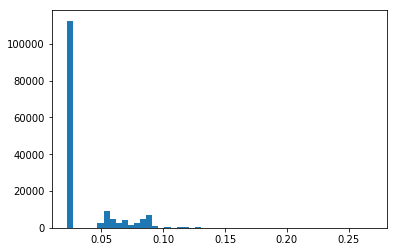

In [595]:
plt.figure()
plt.hist(pred,50)

In [596]:
test_df['probability'] = pred*100

In [597]:
test_collisions = collisions[(prediction_time - datetime.timedelta(seconds=0)).isoformat():(prediction_time + datetime.timedelta(seconds=3600)).isoformat()]

In [598]:
#test_collisions['DDLon'] = -test_collisions['DDLon'] 

In [599]:
#test_df['vis'] = np.log(test_df['probability']) - np.log( test_df.geometry.length)

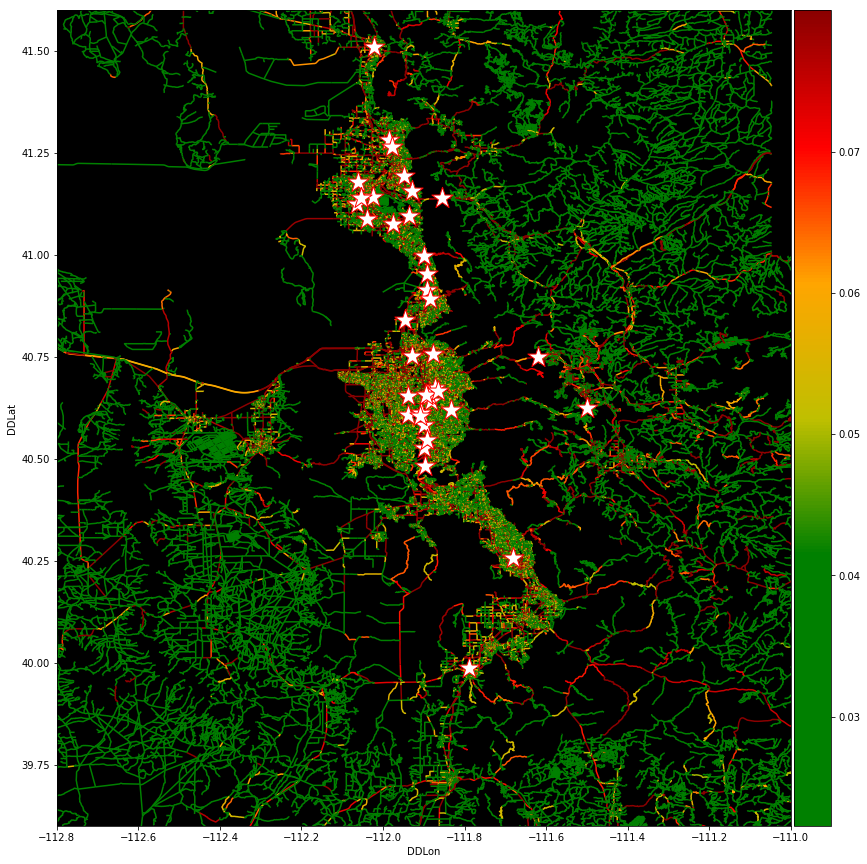

In [618]:
test_df['probability'] = np.minimum(pred,0.08)

fig,ax = plt.subplots()
fig.set_size_inches((15,15))
test_df.plot(ax=ax,column='probability',cmap=cmap)
plt.gca().set_facecolor('k')
plt.imshow(np.array([[test_df.probability.min(),test_df.probability.max()]]),origin='lower',cmap=cmap)
test_collisions.plot.scatter(x='DDLon',y='DDLat',
                             ax=ax,
                             s=500,
                             color='w',
                             zorder=9e99,
                             marker='*',
                             edgecolors='r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
ax.set_xbound(lower=x0,upper=x1)
ax.set_ybound(lower=y0,upper=y1)
plt.colorbar(cax=cax)

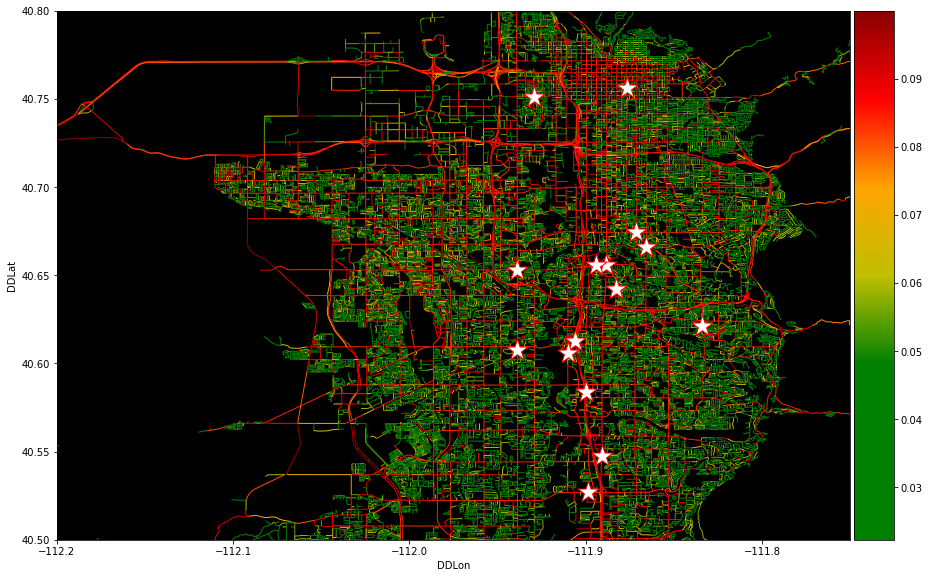

In [614]:
fig,ax = plt.subplots()
fig.set_size_inches((15,15))


test_df.plot(ax=ax,column='probability',cmap=cmap,linewidth=1)
plt.gca().set_facecolor('k')
plt.imshow(np.array([[test_df.probability.min(),test_df.probability.max()]]),origin='lower',cmap=cmap)
test_collisions.plot.scatter(x='DDLon',y='DDLat',
                             ax=ax,
                             s=500,
                             color='w',
                             zorder=9e99,
                             marker='*',
                             edgecolors='r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#''' January
xz0 = -112.2
xz1 = -111.75
yz0 = 40.5
yz1 = 40.8
#'''
ax.set_xbound(lower=xz0,upper=xz1)
ax.set_ybound(lower=yz0,upper=yz1)
plt.colorbar(cax=cax)

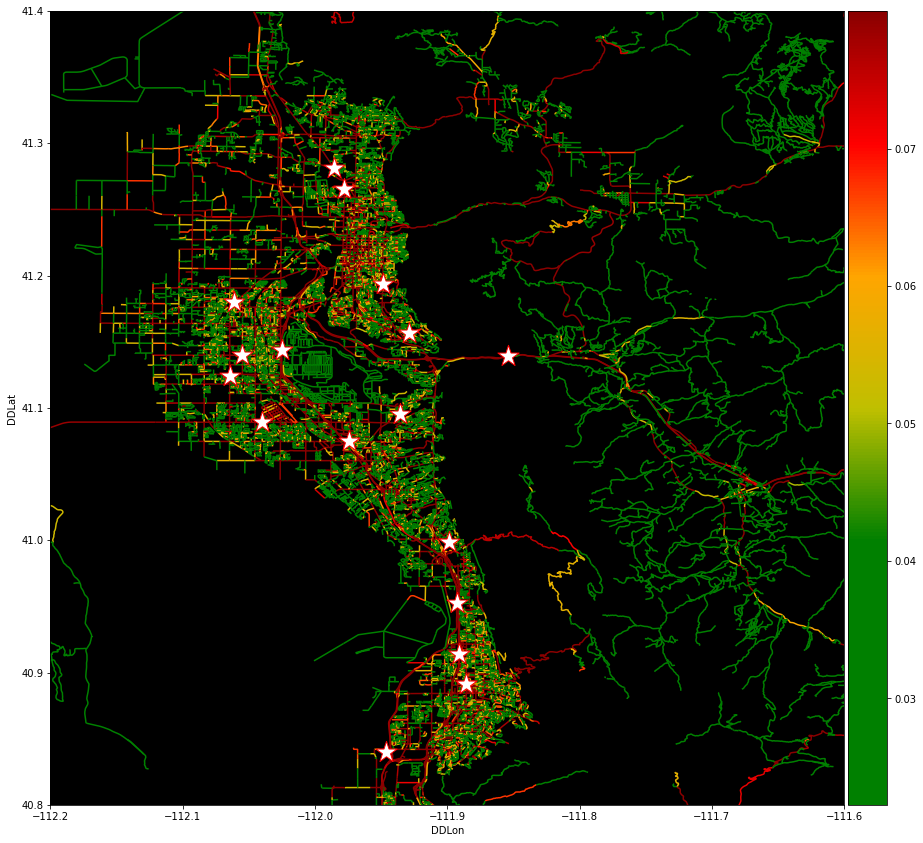

In [602]:
fig,ax = plt.subplots()
fig.set_size_inches((15,15))
test_df.plot(ax=ax,column='probability',cmap=cmap)
plt.gca().set_facecolor('k')

plt.imshow(np.array([[test_df.probability.min(),test_df.probability.max()]]),origin='lower',cmap=cmap)
test_collisions.plot.scatter(x='DDLon',y='DDLat',
                             ax=ax,
                             s=500,
                             color='w',
                             zorder=9e99,
                             marker='*',
                             edgecolors='r')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#'''January
xz0 = -112.2
xz1 = -111.6
yz0 = 40.8
yz1 = 41.4
#'''
''' June
xz0 = -111.6
xz1 = -111.2
yz0 = 40.4
yz1 = 40.8
'''
ax.set_xbound(lower=xz0,upper=xz1)
ax.set_ybound(lower=yz0,upper=yz1)
plt.colorbar(cax=cax)

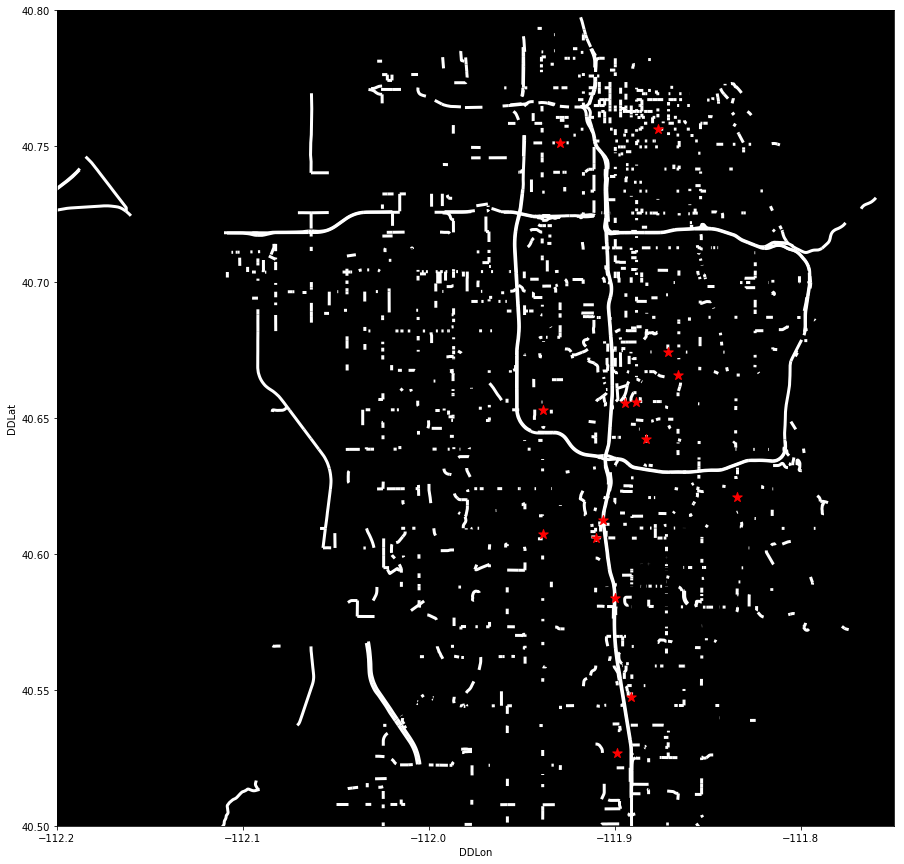

In [617]:
fig,ax = plt.subplots()
fig.set_size_inches((15,15))
try:
    test_df[test_df.probability > .09].plot(ax=ax,color='w',linewidth=3)
except:
    pass
plt.gca().set_facecolor('k')
test_collisions.plot.scatter(x='DDLon',y='DDLat',ax=ax,s=100,color='r',marker='*',zorder=9e99)
#ax.set_xbound(lower=x0,upper=x1)
#ax.set_ybound(lower=y0,upper=y1)
sx0 = -112.2
sx1 = -111.75
sy0 = 40.5
sy1 = 40.8
ax.set_xbound(lower=sx0,upper=sx1)
ax.set_ybound(lower=sy0,upper=sy1)

In [604]:
import arcgis

In [605]:
arcgis.Sp

AttributeError: module 'arcgis' has no attribute 'Sp'